In [39]:
%matplotlib inline

import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.pylab import rcParams

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn import kernel_approximation
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.kernel_approximation import (RBFSampler,Nystroem)
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

rcParams['figure.figsize'] = 15, 5

In [40]:
data = pd.read_csv('../Classification/Ohio/No-show-Issue-Comma-300k.csv')
data.head()

,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Handcap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-29
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Wednesday,Show-Up,0,0,0,0,0,0,0,0,-1
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,0,-1
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Thursday,Show-Up,0,0,0,0,0,0,0,1,-15
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Tuesday,Show-Up,0,0,0,0,0,0,0,1,-6


In [41]:
print(len(data))

300000


In [42]:
#Print of the Frequency of Distinct Values in Each Feature Set

for column in list(data.columns):
    print ("{0:25} {1}".format(column, data[column].nunique()))

Age                       109
Gender                    2
AppointmentRegistration   295425
ApointmentData            534
DayOfTheWeek              7
Status                    2
Diabetes                  2
Alcoolism                 2
HiperTension              2
Handcap                   5
Smokes                    2
Scholarship               2
Tuberculosis              2
Sms_Reminder              3
AwaitingTime              213


In [43]:
#Initialize Function to Plot All Features Within the Dataset

def features_plots(discrete_vars):

    plt.figure(figsize=(15,24.5))

    for i, cv in enumerate(['Age', 'AwaitingTime']):
        plt.subplot(7, 2, i+1)
        plt.hist(data[cv], bins=len(data[cv].unique()))
        plt.title(cv)
        plt.ylabel('Frequency')

    for i, dv in enumerate(discrete_vars):
        plt.subplot(7, 2, i+3)
        data[dv].value_counts().plot(kind='bar', title=dv)
        plt.ylabel('Frequency')

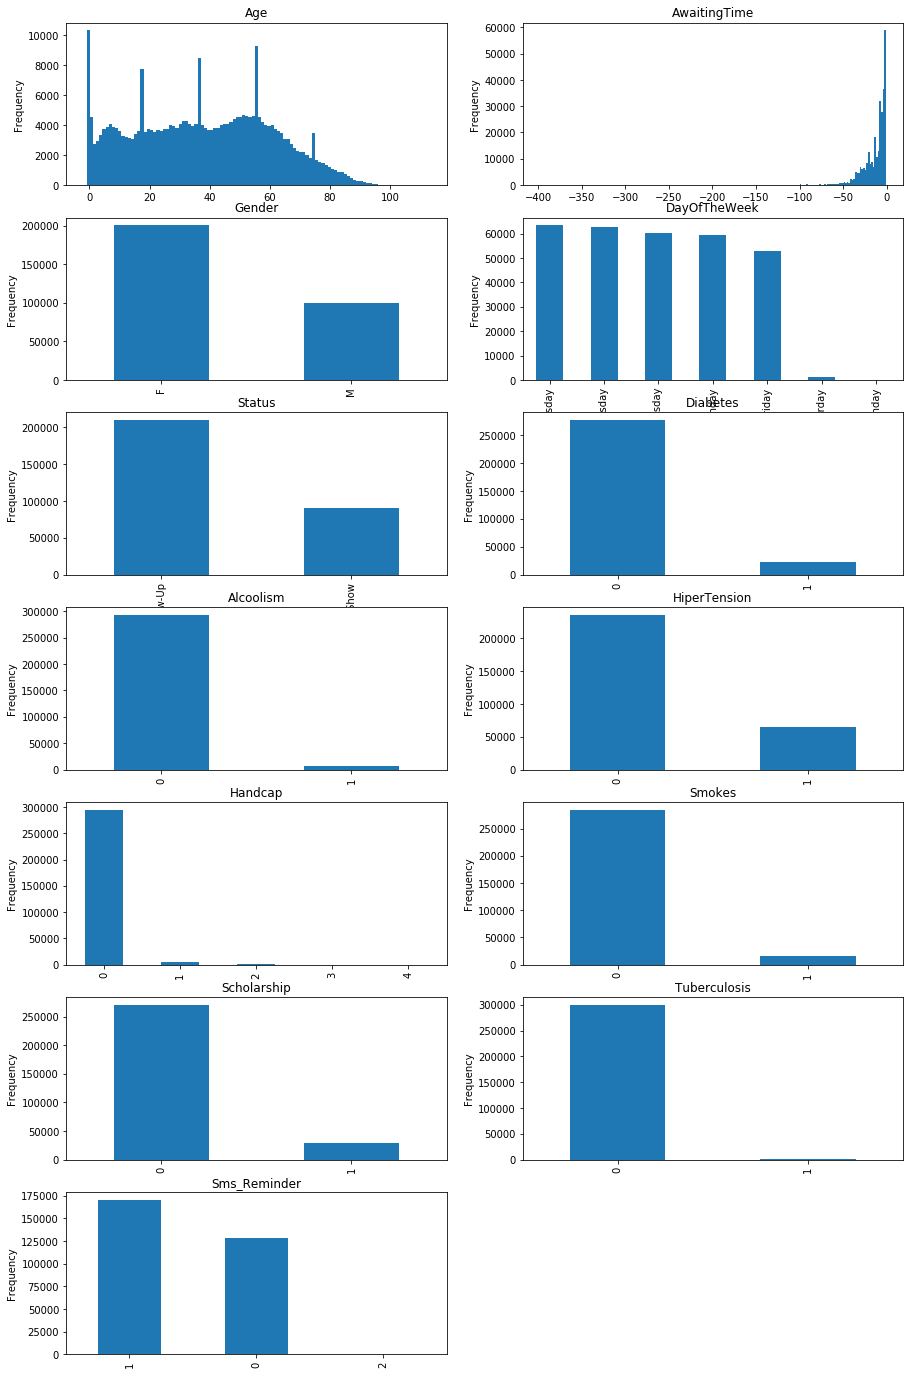

In [44]:
discrete_vars = ['Gender', 'DayOfTheWeek', 'Status', 'Diabetes',
                     'Alcoolism', 'HiperTension', 'Handcap', 'Smokes',
                         'Scholarship', 'Tuberculosis', 'Sms_Reminder']

features_plots(discrete_vars)

There is some noise in the dataset.
    Age: Age lay in the range of -2
    Handicap: Instead of being Boolean, this feature had values in the range of 0 and 4.
    Sms_Reminder: Instead of being a Boolean entity, it had values in the range of 0 and 2.
    AwaitingTime: AwaitingTime can be negative.
So we need to do some data cleaning (or wrangling).

In [45]:
#Counting Frequency of Negative Age Observations

data[data['Age'] < 0]['Age'].value_counts().sum()

6

In [46]:
data = data[data['Age'] >= 0]

In [47]:
#Dropping the feature handicap
del (data['Handcap'])

In [48]:
#Making Values Within AwaitingTime Positive

data['AwaitingTime'] = data['AwaitingTime'].apply(lambda x: abs(x))

In [49]:
#Recode String Categorical Feature DayOfTheWeek to Integers

dow_mapping = {'Monday' : 0, 'Tuesday' : 1, 'Wednesday' : 2,'Thursday' : 3, 'Friday' : 4, 'Saturday' : 5, 'Sunday' : 6}
data['DayOfTheWeek'] = data['DayOfTheWeek'].map(dow_mapping)

In [58]:
#Recode String Categorical Features to Integers
data.Status=pd.Categorical(data.Status)
data.Status=data.Status.cat.codes


In [59]:
data.Gender=pd.Categorical(data.Gender)
data.Gender = data.Gender.cat.codes
#data.Gender.head()

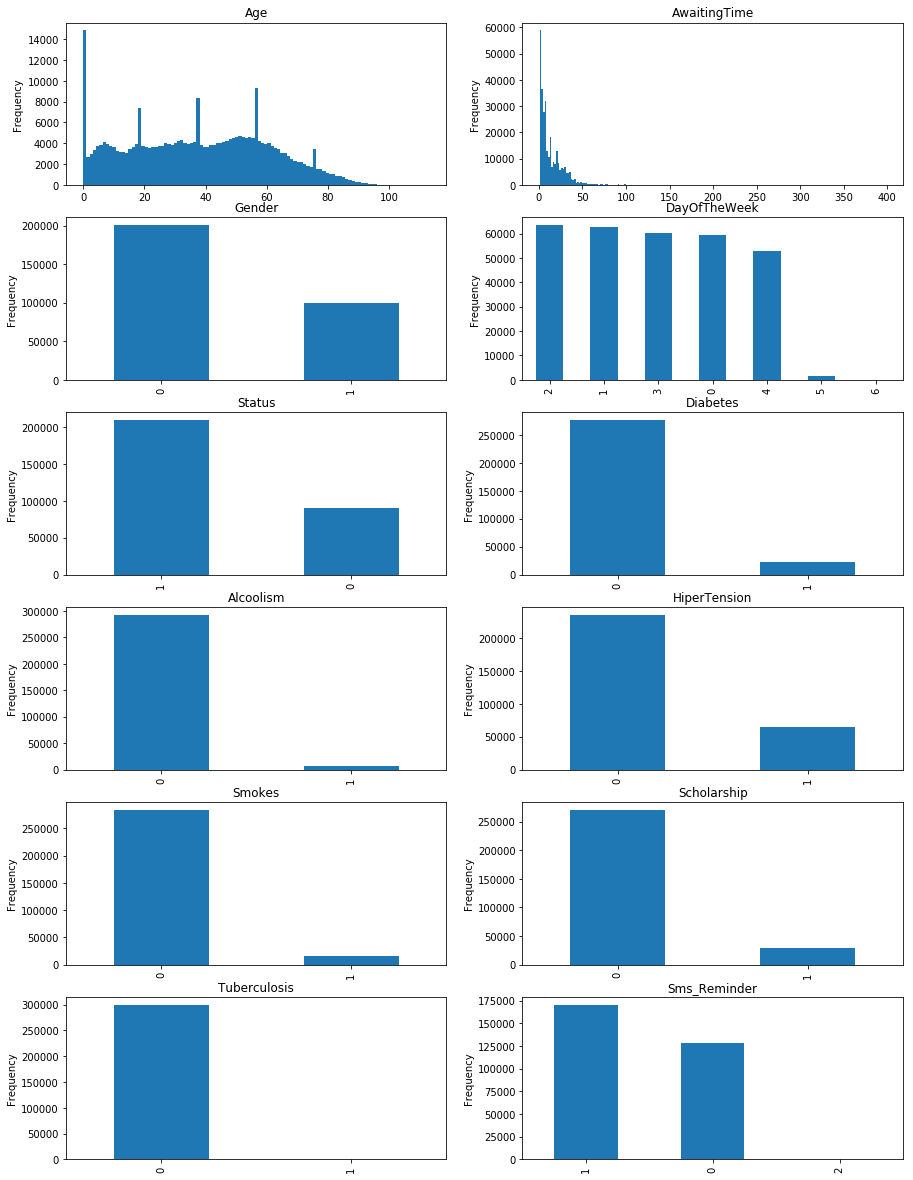

In [60]:
discrete_vars = ['Gender', 'DayOfTheWeek', 'Status', 'Diabetes',
                     'Alcoolism', 'HiperTension', 'Smokes',
                         'Scholarship', 'Tuberculosis', 'Sms_Reminder']

features_plots(discrete_vars)

(0, 120)

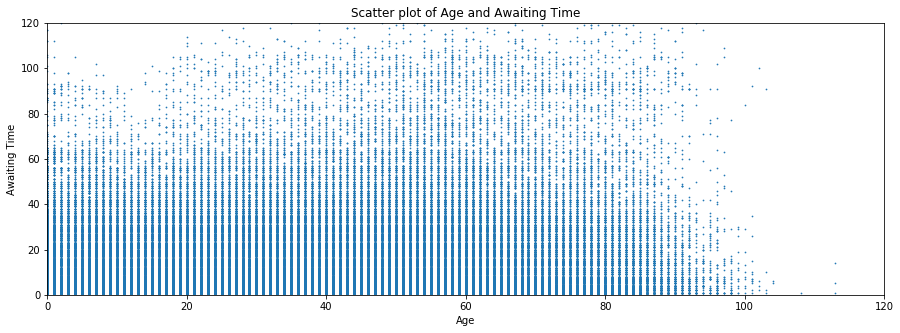

In [61]:
#Scatter Plot Between Age and AwaitingTime
#Shows highly disperse data with no apparent corelation

plt.scatter(data['Age'], data['AwaitingTime'], s=0.5)
plt.title('Scatter plot of Age and Awaiting Time')
plt.xlabel('Age')
plt.ylabel('Awaiting Time')
plt.xlim(0, 120)
plt.ylim(0, 120)

In [62]:
#Calculating Pearson Correlation Between Age and AwaitingTime

pd.set_option('display.width', 100)
pd.set_option('precision', 3)
correlations = data[['Age', 'AwaitingTime']].corr(method='pearson')
print(correlations)

                Age  AwaitingTime
Age           1.000        -0.004
AwaitingTime -0.004         1.000


Text(0, 0.5, 'Frequency')

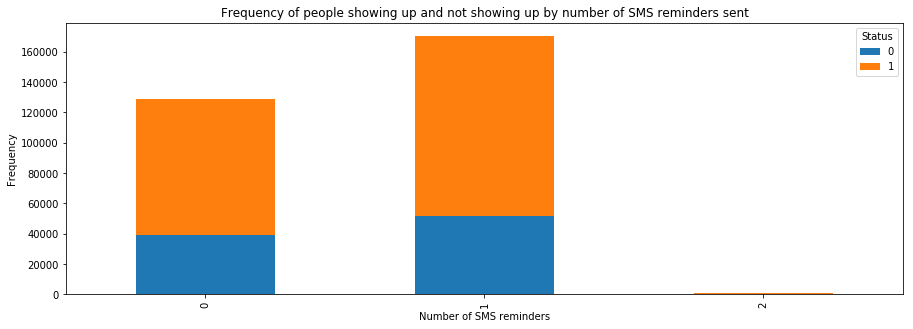

In [63]:
#if the increase in SMS reminders increased the likelihood of a patient showing up or not. 
#Effect on Status on the Basis of Number of SMS Reminders

data_dow_status = data.groupby(['Sms_Reminder', 'Status'])['Sms_Reminder'].count().unstack('Status').fillna(0)
data_dow_status[[0, 1]].plot(kind='bar', stacked=True)
plt.title('Frequency of people showing up and not showing up by number of SMS reminders sent')
plt.xlabel('Number of SMS reminders')
plt.ylabel('Frequency')

In [ ]:
#SMS reminders do marginally increase the likelihood of a patient showing up on 
#his/her appointment day.

Text(0, 0.5, 'Frequency')

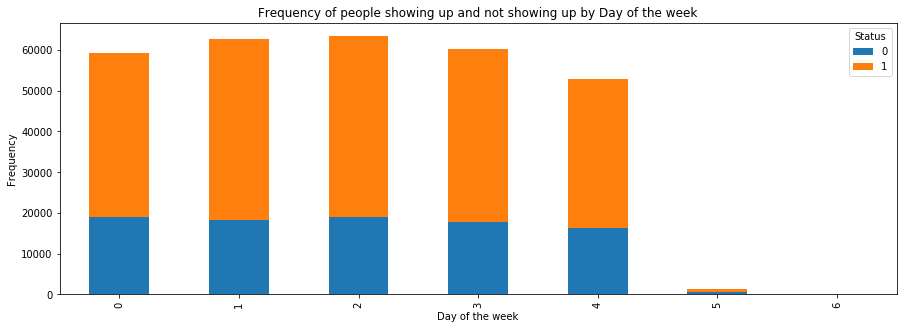

In [64]:
#Effect on Appointment Day of the Week on the Basis of Number of SMS Reminders

data_dow_status = data.groupby(['DayOfTheWeek', 'Status'])['DayOfTheWeek'].count().unstack('Status').fillna(0)
data_dow_status[[0, 1]].plot(kind='bar', stacked=True)
plt.title('Frequency of people showing up and not showing up by Day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Frequency')

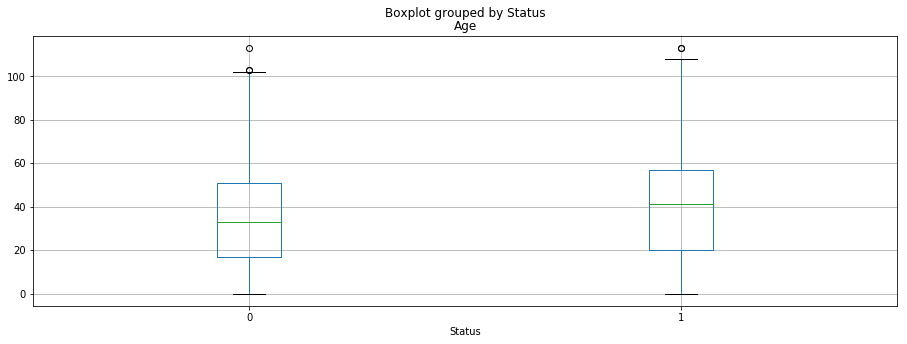

In [65]:
#people who are younger are more likely to be busy and to have a job. Because of that they might be short of time 
#and highly likely to not show up at the time of their appointment.
data.boxplot(column=['Age'], return_type='axes', by='Status')
plt.show()

The hypothesis held true as the median age of people showing up (i.e., 40) 
turned out to be relatively greater than that of those not showing up (i.e., 32). 
Also the upper limit (i.e., quartile 3) of people showing up is 58, 
which is relatively higher than that of those of not showing up (i.e., 52).

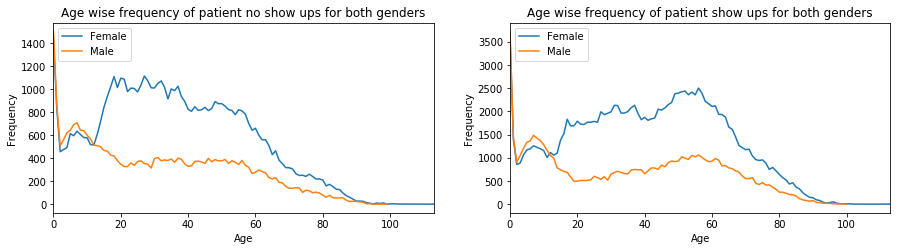

In [66]:
#Plotting Line Plot of Age by Gender for Patients Status-Wise

plt.figure(figsize=(15,3.5))

for i, status in enumerate(['no show ups', 'show ups']):

    data_show = data[data['Status']==i]
    plt.subplot(1, 2, i+1)

    for gender in [0, 1]:
        data_gender = data_show[data_show['Gender']==gender]
        freq_age = data_gender['Age'].value_counts().sort_index()
        freq_age.plot()

    plt.title('Age wise frequency of patient %s for both genders'%status)
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.legend(['Female', 'Male'], loc='upper left')

Age pattern for males seems to be similar for both statuses, contrary to that of females 
which varies across statuses. Females in the age range of 42 to 62 
are likely to show up on the date and time of their appointment.

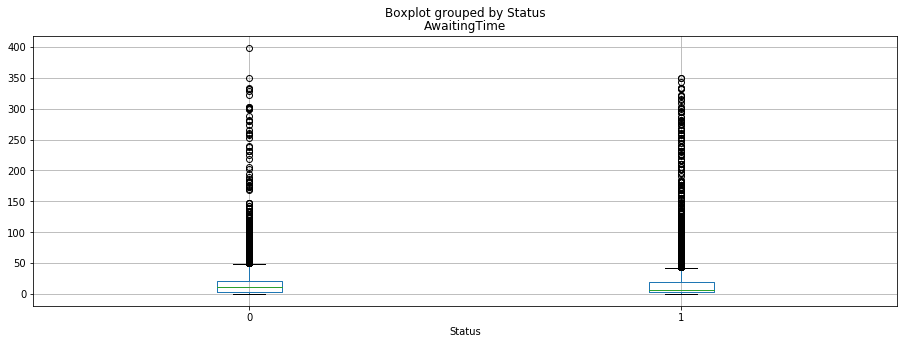

In [67]:
#another reason for not showing up on the appointment date could be that if 
#a disease is seasonal it is likely to be cured after some prevention techniques or 
#home-based remedies. Hence, by the time their appointment date arrives, 
#the patients decide not to consult the doctor. 

#Plotting Box Plot of AwaitingTime by Status

data.boxplot(column=['AwaitingTime'], return_type='axes', by='Status')
plt.show()

#patients who have their AwaitingTime in the third quartile are relatively more likely 
#to not to show up, which supported her earlier laid null hypothesis—with increasing 
#waiting time the likelihood of patient not showing up also increases

In [68]:
#Breaking Date Features into Date Components

for col in ['AppointmentRegistration', 'ApointmentData']:
    for index, component in enumerate(['year', 'month', 'day']):
        data['%s_%s'%(col, component)] = data[col].apply(lambda x: int(x.split('T')[0].split('-')[index]))

In [71]:
#Breaking AppointmentRegistration into Time Components

for index, component in enumerate(['hour', 'min', 'sec']):
    data['%s_%s'%('AppointmentRegistration', component)] = data['AppointmentRegistration'].apply(
       lambda x: int(x.split('T')[1][:-1].split(':')[index]))

In [72]:
data.head()

,Age,Gender,AppointmentRegistration,ApointmentData,DayOfTheWeek,Status,Diabetes,Alcoolism,HiperTension,Smokes,...,AwaitingTime,AppointmentRegistration_year,AppointmentRegistration_month,AppointmentRegistration_day,ApointmentData_year,ApointmentData_month,ApointmentData_day,AppointmentRegistration_hour,AppointmentRegistration_min,AppointmentRegistration_sec
0,19,1,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,2,1,0,0,0,0,...,29,2014,12,16,2015,1,14,14,46,25
1,24,0,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,2,1,0,0,0,0,...,1,2015,8,18,2015,8,19,7,1,26
2,4,0,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,1,1,0,0,0,0,...,1,2014,2,17,2014,2,18,12,53,46
3,5,1,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,3,1,0,0,0,0,...,15,2014,7,23,2014,8,7,17,2,11
4,38,1,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,1,1,0,0,0,0,...,6,2015,10,21,2015,10,27,15,20,9


In [74]:
def model_performance(model_name, X_train, y_train, y_test, Y_pred):

    print ('Model name: %s'%model_name)
    print ('Test accuracy (Accuracy Score): %f'%metrics.accuracy_score(y_test, Y_pred))
    print ('Test accuracy (ROC AUC Score): %f'%metrics.roc_auc_score(y_test, Y_pred))
    print ('Train accuracy: %f'%clf.score(X_train, y_train))

    fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, Y_pred)
    print ('Area Under the Precision-Recall Curve: %f'%metrics.auc(fpr, tpr))

    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, Y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()



In [75]:
features_of_choice = [u'Age', u'Gender', 'DayOfTheWeek', 'Diabetes', 'Alcoolism', 'HiperTension',
                        'Smokes', 'Scholarship', 'Tuberculosis', 'Sms_Reminder',
                        'AwaitingTime', 'AppointmentRegistration_year', 'AppointmentRegistration_month',
                        'AppointmentRegistration_day', 'ApointmentData_year', 'ApointmentData_month',
                        'ApointmentData_day', 'AppointmentRegistration_hour', 'AppointmentRegistration_min',
                        'AppointmentRegistration_sec']

x = np.array(data[features_of_choice])
y = np.array(data['Status'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [76]:
#Decission Tree Classification
clf = DecisionTreeClassifier()
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Model name: Decision tree classifier
Test accuracy (Accuracy Score): 0.588240
Test accuracy (ROC AUC Score): 0.522486
Train accuracy: 0.999952
Area Under the Precision-Recall Curve: 0.112130


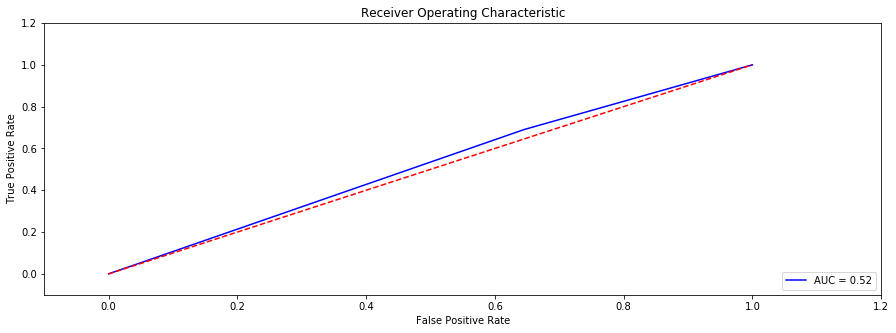

In [77]:
y_pred = clf.predict(x_test)
model_performance('Decision tree classifier', x_train, y_train, y_test, y_pred)